# **Importing required modules**
* pip install pandas
* pip install torch
* pip install sklearn
* pip install transformers
* pip install textblob

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from textblob import TextBlob 

c:\Users\chuac_pvtupth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Importing file**
* Change directory in read_json to file location on your pc

In [84]:
training_data = pd.read_json('C:/Users/koari/OneDrive/Desktop/IE4483 Proj/train.json')
training_data = pd.DataFrame(training_data)

FileNotFoundError: File C:/Users/koari/OneDrive/Desktop/IE4483 Proj/train.json does not exist

# **Cleaning Training Data**

### **Checking that there are no None values in 'Reviews' or 'Sentiment' Column**
* Output shows that there are no None values

In [ ]:
training_data.isnull().sum() 

### **Checking that there are no duplicate data in the training dataset**
* Output shows there are 216 instances of duplicate data

In [ ]:
training_data.duplicated().sum()

### **Removing duplicate data from training dataset**

In [ ]:
training_data=training_data.drop_duplicates()

### **Checking and correcting simple spelling mistakes**
* IE : (Reccomend -> Recommend)
* **WARNING: TAKES VERY LONG TO RUN (30 mins++)** 

In [ ]:
def corrected_spelling(text):
    return str(TextBlob(text).correct())

training_data['reviews']=training_data['reviews'].apply(corrected_spelling)
training_data.to_json(path_or_buf='C:/Users/koari/OneDrive/Desktop/IE4483 Proj/cleaned_train.json', orient='records',lines=True) # Save point

NameError: name 'training_data' is not defined

### **Start here if you do not want to re-preprocess data**
* Loads saved pre-processed data

In [2]:
training_data=pd.read_json('cleaned_train.json',lines=True)
training_data=pd.DataFrame(training_data)

### **Checking for class imbalance**
* Training data has 85% positve reviews
* Class imbalance - impact can be reduced via class weights in training phase

In [3]:
print(training_data.sentiments.value_counts())
print(6139/(1049+6139)*100,"%")

sentiments
1    6136
0    1049
Name: count, dtype: int64
85.4062326099054 %


## **Splitting Training Dataset into a training dataset and testing dataset for binary sentiment classification**
* Random Seed = 42
* Train = 75%, Test = 25% is used but Train = 80%, Test = 20% is another possibility

In [51]:
train_texts, test_texts, train_labels, test_labels = train_test_split(training_data['reviews'], training_data['sentiments'], test_size=0.25, random_state=42)

## **Importing pretrained bert model and tokenizer**

In [52]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Convert the cleaned data into a readable format for the training process using tensor**

In [56]:
# Tokenize the reviews and convert them into BERT's input format
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Convert the labels into torch tensors
train_labels = torch.tensor(train_labels.tolist())
test_labels = torch.tensor(test_labels.tolist())

# Create a dataset class to load the data into PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [16]:
import torch
torch.cuda.empty_cache()

## **Training Process & parameters**
* **WARNING: THIS TAKES 1-2 HRS ON MY PC**

In [53]:
from transformers import TrainingArguments, Trainer, BertForSequenceClassification, BertTokenizer
from transformers import TrainerCallback, EarlyStoppingCallback
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import logging


#Set up logging to a file
logging.basicConfig(filename='training.log', level=logging.INFO, format='%(message)s')

torch.cuda.empty_cache()


# Define training arguments (i might use an algorithm to determine best hyperparameters from an array of values)
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    num_train_epochs=3,              # number of training epochs
    learning_rate=2e-5,              # learning rate
    per_device_train_batch_size=32,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay, prepare to use 0.1
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
)

class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
    
    
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Collect evaluation loss during evaluation
        if 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])
            print(f"Evaluation loss appended: {metrics['eval_loss']}")  # Debug print

            print("Current log history:", state.log_history)  # Debug print

# Create the Trainer object
loss_logger = LossLoggerCallback()
trainer = Trainer(
    model=model,                         # the pre-trained BERT model
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    callbacks=[loss_logger]              # add the custom callback
)


# Fine-tune the model
trainer.train()

 19%|█▊        | 100/540 [01:04<04:49,  1.52it/s]

{'loss': 0.5193, 'grad_norm': 3.619032859802246, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.56}



 19%|█▊        | 100/540 [01:15<04:49,  1.52it/s]

{'eval_loss': 0.38946935534477234, 'eval_runtime': 10.0978, 'eval_samples_per_second': 142.309, 'eval_steps_per_second': 2.278, 'epoch': 0.56}
Evaluation loss appended: 0.38946935534477234
Current log history: [{'loss': 0.5193, 'grad_norm': 3.619032859802246, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5555555555555556, 'step': 100}, {'eval_loss': 0.38946935534477234, 'eval_runtime': 10.0978, 'eval_samples_per_second': 142.309, 'eval_steps_per_second': 2.278, 'epoch': 0.5555555555555556, 'step': 100}]


 37%|███▋      | 200/540 [02:21<03:47,  1.50it/s]

{'loss': 0.2697, 'grad_norm': 5.551860332489014, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.11}



 37%|███▋      | 200/540 [02:31<03:47,  1.50it/s]

{'eval_loss': 0.17193549871444702, 'eval_runtime': 10.3038, 'eval_samples_per_second': 139.463, 'eval_steps_per_second': 2.232, 'epoch': 1.11}
Evaluation loss appended: 0.17193549871444702
Current log history: [{'loss': 0.5193, 'grad_norm': 3.619032859802246, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5555555555555556, 'step': 100}, {'eval_loss': 0.38946935534477234, 'eval_runtime': 10.0978, 'eval_samples_per_second': 142.309, 'eval_steps_per_second': 2.278, 'epoch': 0.5555555555555556, 'step': 100}, {'loss': 0.2697, 'grad_norm': 5.551860332489014, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.1111111111111112, 'step': 200}, {'eval_loss': 0.17193549871444702, 'eval_runtime': 10.3038, 'eval_samples_per_second': 139.463, 'eval_steps_per_second': 2.232, 'epoch': 1.1111111111111112, 'step': 200}]


 56%|█████▌    | 300/540 [03:38<02:39,  1.50it/s]

{'loss': 0.1578, 'grad_norm': 14.105040550231934, 'learning_rate': 1.2e-05, 'epoch': 1.67}


                                                 
 56%|█████▌    | 300/540 [03:48<02:39,  1.50it/s]

{'eval_loss': 0.1782170534133911, 'eval_runtime': 10.285, 'eval_samples_per_second': 139.718, 'eval_steps_per_second': 2.236, 'epoch': 1.67}
Evaluation loss appended: 0.1782170534133911
Current log history: [{'loss': 0.5193, 'grad_norm': 3.619032859802246, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5555555555555556, 'step': 100}, {'eval_loss': 0.38946935534477234, 'eval_runtime': 10.0978, 'eval_samples_per_second': 142.309, 'eval_steps_per_second': 2.278, 'epoch': 0.5555555555555556, 'step': 100}, {'loss': 0.2697, 'grad_norm': 5.551860332489014, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.1111111111111112, 'step': 200}, {'eval_loss': 0.17193549871444702, 'eval_runtime': 10.3038, 'eval_samples_per_second': 139.463, 'eval_steps_per_second': 2.232, 'epoch': 1.1111111111111112, 'step': 200}, {'loss': 0.1578, 'grad_norm': 14.105040550231934, 'learning_rate': 1.2e-05, 'epoch': 1.6666666666666665, 'step': 300}, {'eval_loss': 0.1782170534133911, 'eval_runtime': 10.285, 'eval_sam

 74%|███████▍  | 400/540 [04:55<01:34,  1.49it/s]

{'loss': 0.1399, 'grad_norm': 6.869294166564941, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.22}



 74%|███████▍  | 400/540 [05:05<01:34,  1.49it/s]

{'eval_loss': 0.1850305199623108, 'eval_runtime': 10.3304, 'eval_samples_per_second': 139.104, 'eval_steps_per_second': 2.226, 'epoch': 2.22}
Evaluation loss appended: 0.1850305199623108
Current log history: [{'loss': 0.5193, 'grad_norm': 3.619032859802246, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5555555555555556, 'step': 100}, {'eval_loss': 0.38946935534477234, 'eval_runtime': 10.0978, 'eval_samples_per_second': 142.309, 'eval_steps_per_second': 2.278, 'epoch': 0.5555555555555556, 'step': 100}, {'loss': 0.2697, 'grad_norm': 5.551860332489014, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.1111111111111112, 'step': 200}, {'eval_loss': 0.17193549871444702, 'eval_runtime': 10.3038, 'eval_samples_per_second': 139.463, 'eval_steps_per_second': 2.232, 'epoch': 1.1111111111111112, 'step': 200}, {'loss': 0.1578, 'grad_norm': 14.105040550231934, 'learning_rate': 1.2e-05, 'epoch': 1.6666666666666665, 'step': 300}, {'eval_loss': 0.1782170534133911, 'eval_runtime': 10.285, 'eval_sa

 93%|█████████▎| 500/540 [06:13<00:26,  1.48it/s]

{'loss': 0.103, 'grad_norm': 5.913818359375, 'learning_rate': 2e-05, 'epoch': 2.78}



 93%|█████████▎| 500/540 [06:23<00:26,  1.48it/s]

{'eval_loss': 0.18244986236095428, 'eval_runtime': 10.4439, 'eval_samples_per_second': 137.593, 'eval_steps_per_second': 2.202, 'epoch': 2.78}
Evaluation loss appended: 0.18244986236095428
Current log history: [{'loss': 0.5193, 'grad_norm': 3.619032859802246, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.5555555555555556, 'step': 100}, {'eval_loss': 0.38946935534477234, 'eval_runtime': 10.0978, 'eval_samples_per_second': 142.309, 'eval_steps_per_second': 2.278, 'epoch': 0.5555555555555556, 'step': 100}, {'loss': 0.2697, 'grad_norm': 5.551860332489014, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.1111111111111112, 'step': 200}, {'eval_loss': 0.17193549871444702, 'eval_runtime': 10.3038, 'eval_samples_per_second': 139.463, 'eval_steps_per_second': 2.232, 'epoch': 1.1111111111111112, 'step': 200}, {'loss': 0.1578, 'grad_norm': 14.105040550231934, 'learning_rate': 1.2e-05, 'epoch': 1.6666666666666665, 'step': 300}, {'eval_loss': 0.1782170534133911, 'eval_runtime': 10.285, 'eval_

100%|██████████| 540/540 [06:53<00:00,  1.30it/s]

{'train_runtime': 413.8244, 'train_samples_per_second': 41.67, 'train_steps_per_second': 1.305, 'train_loss': 0.22753495022102638, 'epoch': 3.0}


TrainOutput(global_step=540, training_loss=0.22753495022102638, metrics={'train_runtime': 413.8244, 'train_samples_per_second': 41.67, 'train_steps_per_second': 1.305, 'total_flos': 1134271759656960.0, 'train_loss': 0.22753495022102638, 'epoch': 3.0})

In [ ]:
# Evaluate the best model
# best_model_metrics = trainer.evaluate()

# Print the evaluation metrics of the best model
# print("Best model evaluation metrics:", best_model_metrics)

100%|██████████| 23/23 [00:10<00:00,  2.28it/s]

Evaluation loss appended: 0.1572885811328888
Current log history: [{'loss': 0.5012, 'grad_norm': 2.500086784362793, 'learning_rate': 1e-05, 'epoch': 0.2777777777777778, 'step': 100}, {'eval_loss': 0.39690762758255005, 'eval_runtime': 9.7546, 'eval_samples_per_second': 147.316, 'eval_steps_per_second': 2.358, 'epoch': 0.2777777777777778, 'step': 100}, {'loss': 0.2722, 'grad_norm': 7.965726375579834, 'learning_rate': 2e-05, 'epoch': 0.5555555555555556, 'step': 200}, {'eval_loss': 0.2981533408164978, 'eval_runtime': 9.9543, 'eval_samples_per_second': 144.36, 'eval_steps_per_second': 2.311, 'epoch': 0.5555555555555556, 'step': 200}, {'loss': 0.1963, 'grad_norm': 12.728821754455566, 'learning_rate': 1.6153846153846154e-05, 'epoch': 0.8333333333333334, 'step': 300}, {'eval_loss': 0.15725408494472504, 'eval_runtime': 10.1262, 'eval_samples_per_second': 141.909, 'eval_steps_per_second': 2.271, 'epoch': 0.8333333333333334, 'step': 300}, {'loss': 0.1409, 'grad_norm': 0.923308789730072, 'learning

## **Performing analysis on test set & Calculation of  Accuracy, Precision, Recall, F1-Score for further fine tuning**

In [57]:
# Predict on the test dataset
predictions = trainer.predict(test_dataset)

# Get the predicted labels
preds = torch.argmax(torch.from_numpy(predictions.predictions), axis=-1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

Accuracy: 0.9532554257095158
Precision: 0.9630102040816326
Recall: 0.9830729166666666
F1-score: 0.9729381443298969


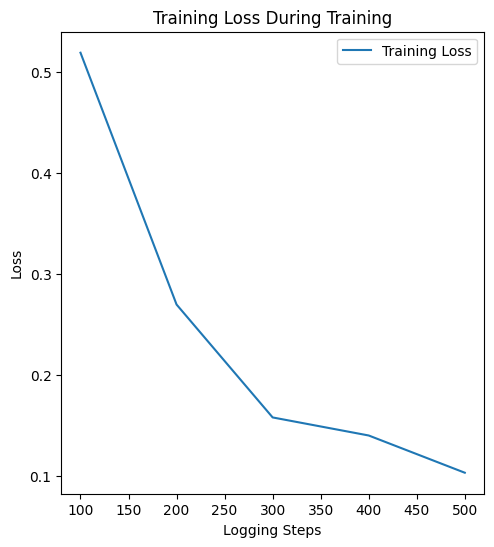

In [58]:
train_losses = []
steps = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
        steps.append(log['step'])

# Plot the training loss
plt.figure(figsize=(12, 6))
# Plot evaluation loss
plt.subplot(1, 2, 2)
plt.plot(steps, train_losses, label='Training Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training Loss During Training')
plt.legend()
plt.show()

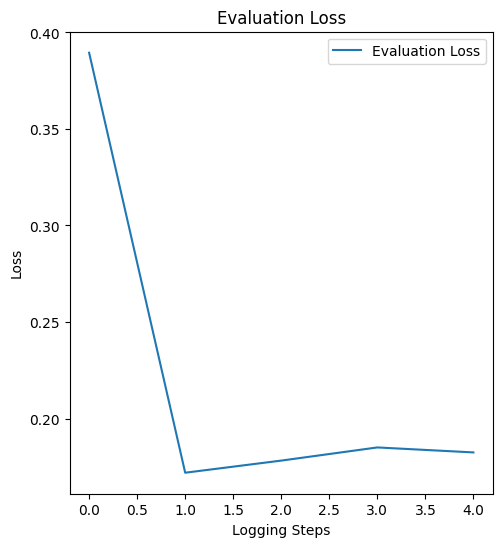

In [59]:
# Fine-tune the model

# Plot the training and evaluation losses
plt.figure(figsize=(12, 6))
# Plot evaluation loss
plt.subplot(1, 2, 2)
plt.plot(loss_logger.eval_losses, label='Evaluation Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.show()

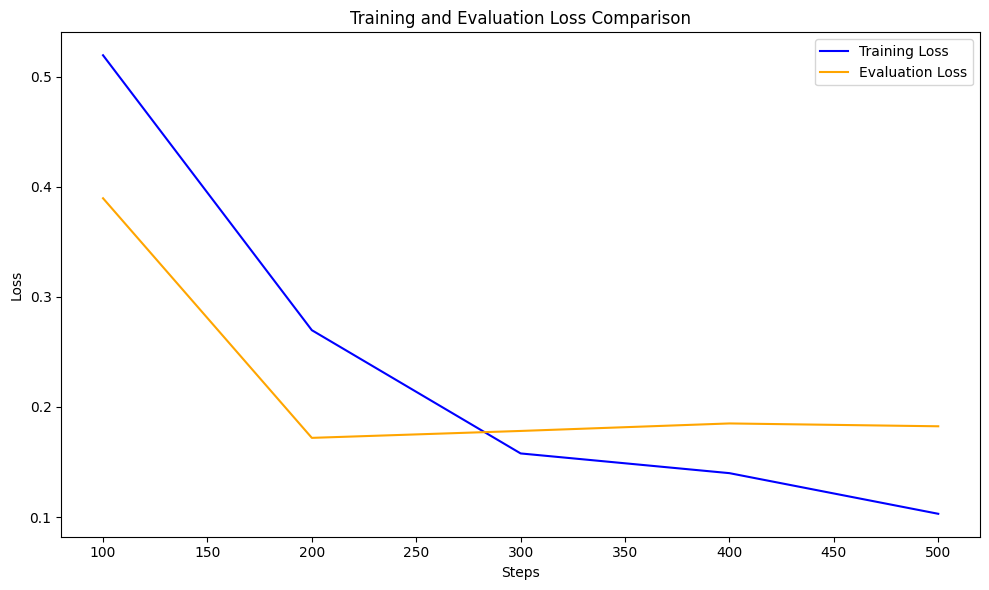

In [60]:
# Create training steps as a range for the number of training losses
# Training starts at step 0
train_steps = [i * 100 + 100 for i in range(len(train_losses))]  # 100 steps for each entry in train_losses

# Create evaluation steps, adjusting them so that they start at 0 as well
# Assuming eval_steps increments by 100, but starts at 100 for the first evaluation point
eval_steps = [i * 100 + 100 for i in range(len(loss_logger.eval_losses))]  # Starts at 100 steps for eval

# Plot both training and evaluation losses on the same plot
plt.figure(figsize=(10, 6))

# Plot training loss (using train_steps)
plt.plot(train_steps, train_losses, label='Training Loss', color='blue')

# Plot evaluation loss (using eval_steps)
plt.plot(eval_steps, loss_logger.eval_losses, label='Evaluation Loss', color='orange')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Comparison')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# **Save model and tokenizer**
* **DO NOT RUN if you have not trained the model above** 

In [61]:
model.save_pretrained('./ch_BERT_final_model')
tokenizer.save_pretrained('./ch_BERT_final_model')

('./ch_BERT_final_model\\tokenizer_config.json',
 './ch_BERT_final_model\\special_tokens_map.json',
 './ch_BERT_final_model\\vocab.txt',
 './ch_BERT_final_model\\added_tokens.json')

## **Load model and tokenizer**
* **Start here to skip data pre-processing & model training** 

In [62]:
tokenizer = BertTokenizer.from_pretrained('./ch_BERT_final_model')
model = BertForSequenceClassification.from_pretrained('./ch_BERT_final_model')

# **Import test.json for prediction**

In [63]:
prediction_data = pd.read_json('test.json')
prediction_data = pd.DataFrame(prediction_data)

# **Performing prediction and storing to new data frame**

In [64]:
def predict_sentiment(review):
    # Tokenize the review
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    # Perform the prediction
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Return Sentiment Value (0 for negative, 1 for postive)
    return torch.argmax(probs).item()

# Stores the sentiments in a list
prediction_list = []
for row in range(len(prediction_data)):
    prediction_list.append(predict_sentiment(prediction_data.iloc[row][0]))

# Append the sentiment list to the a new dataframe
finalized_prediction = prediction_data.assign(sentiment=prediction_list)

C:\Users\chuac_pvtupth\AppData\Local\Temp\ipykernel_34480\356560487.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediction_list.append(predict_sentiment(prediction_data.iloc[row][0]))


# **Store the finalized prediction in CSV File**

In [65]:
# Save the new datafram into a json file
finalized_prediction.to_csv(path_or_buf='ch_BERT_final_output.csv')